In [138]:
import numpy as np 
from scipy.linalg import svdvals
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tqdm.notebook import tqdm
from scipy.stats import spearmanr,kendalltau
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
def rl_svd(A_d, V, mode):
    """right(left) svd decomposition. Returns U_d(V_d) based on input original V(U)"""
    m, n = A_d.shape
    r_max = min(m, n) # max matrix rank

    if mode == 'right': # than V is actually V in SVD and we perform right svd
        U_d = A_d @ V[:, :r_max]
        U_d_n = np.zeros((m, m)) # preparation for normalized U_d
    elif mode == 'left': # than V is actually U in SVD and we perform left svd
        U_d = A_d.T @ V[:, :r_max]
        U_d_n = np.zeros((n, n)) # preparation for normalized U_d
    else:
        raise ValueError('Mode can be left or right')

    # get singular values and set them to zero if less then s_thr
    s = np.linalg.norm(U_d, axis=0)
    s_thr = 1e-12
    ind = (s >= s_thr)
    s[s < s_thr] = 0
    r = np.count_nonzero(s)

    U_d_n[:, ind] = U_d[:, ind] / s[ind]
    return U_d_n, s

In [3]:
# def get_cpf(S, Su, Sv):
#     def thr(cpf):
#         (abs(S - Su)+ abs(S - Sv))[:cpf] / (abs(S - Su)+ abs(S - Sv))[:cpf]

In [4]:
def SSVD(A_d, u_t, s_t, v_t, w, cpf):
    ''' Factor of structural distortion
        A_d - distorted block
        CPF - CooPerative Factor (threshold of svd)
    '''
    # u_t, s_t, vh_t = np.linalg.svd(A_t)
    # v_t = vh_t.T
    # w = s_t / np.sum(s_t) + c

    # Sv
    u_d, s_d_u = rl_svd(A_d, v_t, mode='right')
    I_d_u = u_t @ u_d.T 
    S_v = svdvals(I_d_u)   

    # Su
    v_d, s_d_v = rl_svd(A_d, u_t, mode='left')
    I_d_v = v_t @ v_d.T 
    S_u = svdvals(I_d_v)

    # Fs
    Fsv = np.sqrt(np.sum(((S_v - 1) * w)[:cpf] ** 2 ))
    Fsu = np.sqrt(np.sum(((S_u - 1) * w)[:cpf] ** 2 ))

    Fs = (Fsv + Fsu) / 2

    # Fl
    Flv = np.sqrt(np.sum((abs(s_d_v - s_t) * w)[:cpf]))
    Flu = np.sqrt(np.sum((abs(s_d_u - s_t) * w)[:cpf]))
    Fl = (Flu + Flv) / 2

    # Fr
    S_d = svdvals(A_d)
    Qsv = np.sqrt(np.sum((S_d - s_d_v)[:cpf] ** 2))
    Qsu = np.sqrt(np.sum((S_d - s_d_u)[:cpf] ** 2))

    eps = 1e-2
    Qrh = 2 * Qsu * Qsv / (Qsu + Qsv + eps)

    h = 4 * A_t.shape[0]
    Fr = 1 - np.exp(-Qrh / h)

    return np.array([Fl, Fs, Fr])

In [5]:
def im2mat(path,pad_n=3, pad_m=1):
    '''PIL image to greyscale np.array with pads'''
    im = ImageOps.grayscale(Image.open(path))
    im = np.array(im)
    im = np.pad(im, ((0, pad_n),(0, pad_m)))
    return im
    
def mat2block(A, block_n, block_m):
    '''Crop matrix into blocks'''
    n, m = A.shape
    B = []
    for rect in np.array_split(A, n / block_n, axis=0):
        for block in np.array_split(rect, m / block_m, axis=1):
            B.append(block)
    return np.array(B)

In [6]:
block_size = 9
n, m = 384, 512
pad_n = block_size - n % block_size
pad_m = block_size - m % block_size
c = 0.01

n_im = 25 # 25
n_dist = 24 #24
n_level = 5

F, Fl, Fs, Fr = ([],[],[],[])


for i in tqdm(range(1, n_im + 1)): # over images

    # download target image
    im_path = 'tid2013/reference_images/i' + "{0:0=2d}".format(i) + '.bmp'
    I_t = im2mat(im_path)

    # crop it into blocks
    I_t_bl = mat2block(I_t, block_size, block_size) # array of blocks

    # distorted images
    n_blocks = I_t_bl.shape[0]

    # same for distorted images correspondint the the ith target image
    I_d = []
    for d in range(1, n_dist + 1): # over distortion types
            for l in range(1, n_level + 1): # over level of distortion 
                im_path = 'tid2013/distorted_images/i' + "{0:0=2d}".format(i) + '_' + "{0:0=2d}".format(d) + '_' + str(l) + '.bmp'
                i_d = im2mat(im_path)
                I_d.append(i_d)

    I_d_bl = np.array([mat2block(i_d, block_size, block_size) for i_d in I_d]).swapaxes(0,1) # array of block arrays

    # now run over blocks and compute corresponding F
    f = []
    for b in range(n_blocks):
        A_t = I_t_bl[b]

        u_t, s_t, vh_t = np.linalg.svd(A_t)
        v_t = vh_t.T
        w = s_t / np.sum(s_t) + c
        f_block = [SSVD(A_d, u_t, s_t, v_t, w, 7) for A_d in I_d_bl[b]]
        f.append(f_block)
    f = np.array(f)
    
    F.append(np.mean(np.prod(f, axis=2), axis=0))
    Fl.append(np.mean(f[:,:,0], axis=0))
    Fs.append(np.mean(f[:,:,1], axis=0))
    Fr.append(np.mean(f[:,:,2], axis=0))

F = np.array(F)
Fl = np.array(Fl)
Fs = np.array(Fs)
Fr = np.array(Fr)

/home/koritskiy/anaconda3/envs/hamiltonian_learning/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [11]:
# Save the results
np.save('tid2013/results/F', F)
np.save('tid2013/results/Fl', Fl)
np.save('tid2013/results/Fs', Fs)
np.save('tid2013/results/Fr', Fr)

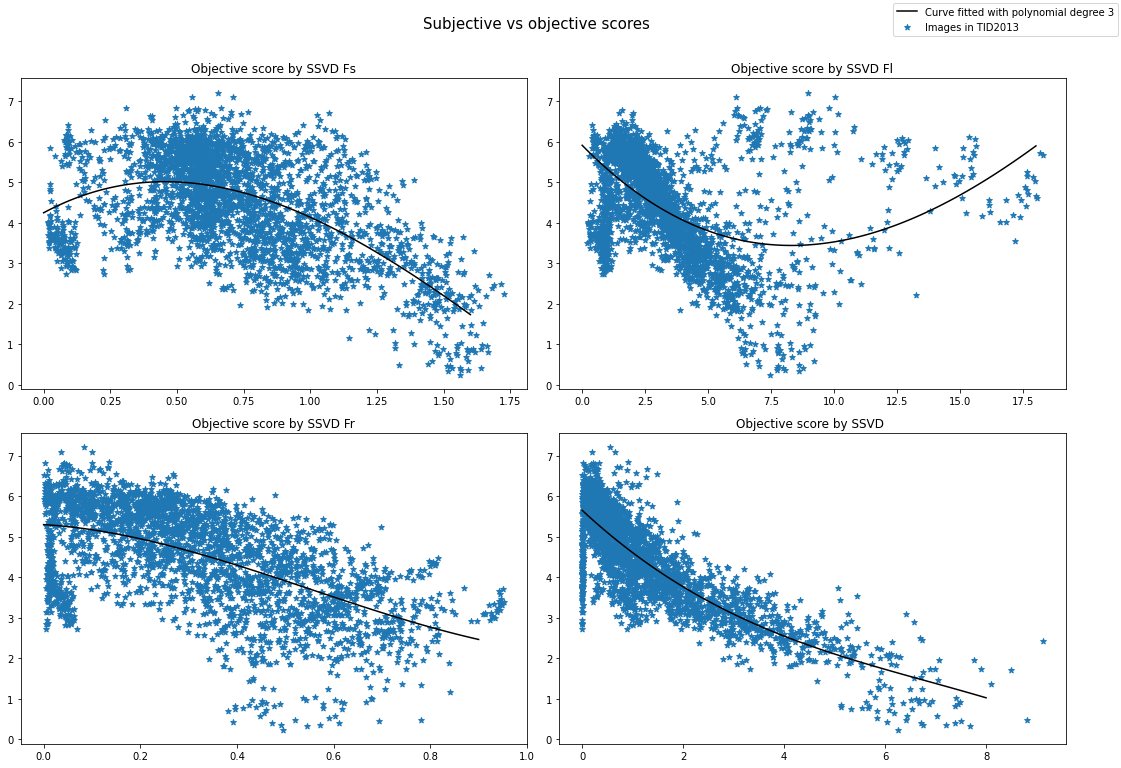

In [85]:
# Get subjective estimations
mos = open('tid2013/mos.txt', 'r').read().split('\n')
mos = np.array([float(i) for i in mos])
Y = mos[:(n_im -1)* n_dist * n_level]


fig, axs = plt.subplots(2, 2, figsize=(15,10))
model = make_pipeline(PolynomialFeatures(3), Ridge())

X = Fs[:-1].reshape(-1,1)
model.fit(X, Y)
X_plot = np.linspace(0,1.6,100).reshape(-1,1)
axs[0, 0].scatter(X, Y, label='Images in TID2013', marker='*')
axs[0, 0].plot(X_plot,model.predict(X_plot), label='Curve fitted with polynomial degree 3', color='black')
axs[0, 0].set_title('Objective score by SSVD Fs')

X = Fl[:-1].reshape(-1,1)
X_plot = np.linspace(0,18,100).reshape(-1,1)
model.fit(X, Y)
axs[0, 1].scatter(X, Y,  marker='*')
axs[0, 1].plot(X_plot,model.predict(X_plot), color='black')
axs[0, 1].set_title('Objective score by SSVD Fl')

X = Fr[:-1].reshape(-1,1)
X_plot = np.linspace(0,0.9,100).reshape(-1,1)
model.fit(X, Y)
axs[1, 0].scatter(X, Y, marker='*')
axs[1, 0].plot(X_plot,model.predict(X_plot), color='black')
axs[1, 0].set_title('Objective score by SSVD Fr')

X = F[:-1].reshape(-1,1)
X_plot = np.linspace(0,8,100).reshape(-1,1)
model.fit(X, Y)
axs[1, 1].scatter(X, Y, marker='*')
axs[1, 1].plot(X_plot,model.predict(X_plot), color='black')
axs[1, 1].set_title('Objective score by SSVD ')

fig.legend(bbox_to_anchor=(0.04, 0.82, 1., .25));
fig.suptitle('Subjective vs objective scores', y=1.05, fontsize=15)
plt.tight_layout()

In [102]:
mos_tens = mos[:(n_im -1)* n_dist * n_level].reshape(n_im-1,n_dist,n_level)
SROCC = np.array([spearmanr(F[:-1][:, d*n_level:(d+1)*n_level].flatten(), mos_tens[:,d, :].flatten())[0] for d in range(n_dist)])   

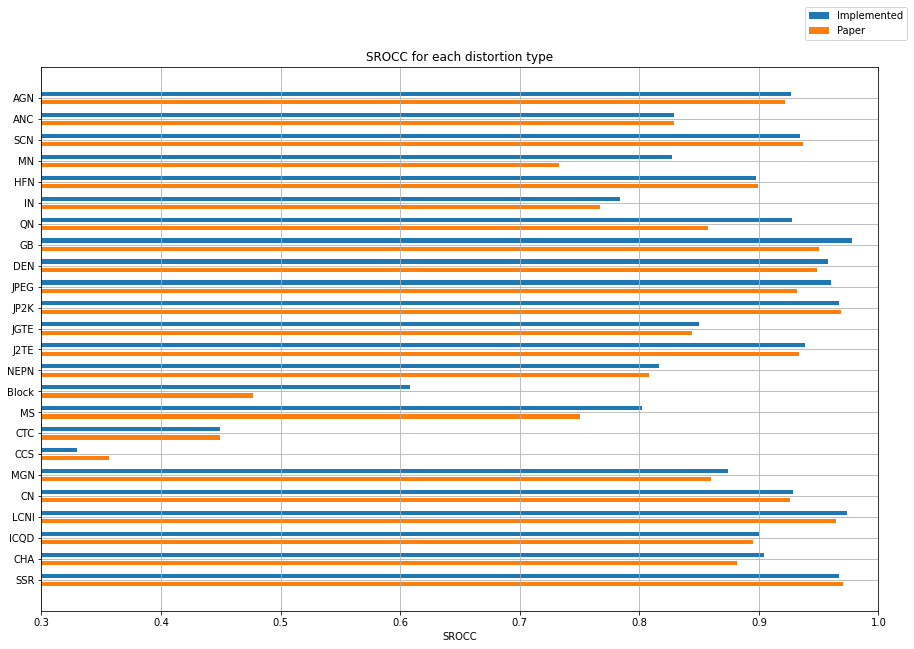

In [137]:
fig, ax = plt.subplots(figsize=(15,10))

h = 0.2
distortions = ('AGN','ANC','SCN','MN','HFN','IN','QN','GB','DEN','JPEG','JP2K','JGTE','J2TE','NEPN','Block','MS','CTC','CCS','MGN','CN','LCNI','ICQD','CHA','SSR')
paper_SROCC = [0.9221,0.8289,0.9369,0.7325,0.8995,0.7671,0.8572,0.9499,0.9486,0.9318,0.9688,0.8441,0.9332,0.8085,0.4768,0.7507,0.4494,0.3562,0.8600,0.9263,0.9649,0.8948,0.8816,0.9700]
y_pos = np.arange(len(distortions))


ax.barh(y_pos-w, abs(SROCC), height=h,align='center', label='Implemented')
ax.barh(y_pos+w, paper_SROCC, height=h,align='center', label='Paper')
ax.set_yticks(y_pos)
ax.set_yticklabels(distortions)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('SROCC')
ax.set_title('SROCC for each distortion type')

plt.xlim(0.3,1)
plt.grid()
plt.legend(bbox_to_anchor=(0.04, 0.82, 1., .3))
plt.show()

In [151]:
SROCC_tot = spearmanr(F[:-1].flatten(), mos_tens.flatten())[0]
KROCC_tot = kendalltau(F[:-1], mos_tens.flatten())[0]

SROCC_tot_paper = 0.811
KROCC_tot_paper = 0.647

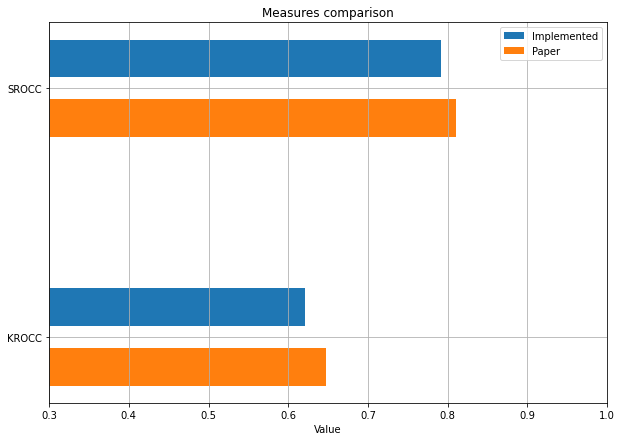

In [170]:
ig, ax = plt.subplots(figsize=(10,7))

h = 0.05
measures = ('SROCC','KROCC')
paper = [SROCC_tot_paper, KROCC_tot_paper]
impl = np.array([SROCC_tot, KROCC_tot])
y_pos = np.arange(len(measures))/3


ax.barh(y_pos-w/5, abs(impl), height=h,align='center', label='Implemented')
ax.barh(y_pos+w/5, paper, height=h,align='center', label='Paper')
ax.set_yticks(y_pos)
ax.set_yticklabels(measures)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Value')
ax.set_title('Measures comparison')

plt.xlim(0.3,1)
plt.grid()
plt.legend()
plt.show()